# DATA PREPROCESSING

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn


 

weather = pd.read_csv('Weather_Data_Germany.csv')
weather['test'] = 0
weather.drop('forecast_origin', axis=1, inplace=True)
weather['time'] = pd.to_datetime(weather['time'], format='%Y-%m-%d %H:%M:%S')

weather_2022 = pd.read_csv('Weather_Data_Germany_2022.csv')
weather_2022['test'] = 1
weather_2022.drop('forecast_origin', axis=1, inplace=True)
weather_2022['time'] = pd.to_datetime(weather_2022['time'], format='%Y-%m-%d %H:%M:%S')

weather = pd.concat([weather, weather_2022], axis=0)

weather_mean = weather.groupby('time').mean(numeric_only=True)
weather_mean.drop(['longitude', 'latitude'], axis=1, inplace=True)


weather['time'] = pd.to_datetime(weather['time'])
weather = weather.sort_values('time').set_index('time')


demand = pd.read_csv('Reaslised_Demand_Germany.csv', sep=";")
# Format - 01.01.19 00:00 
demand['Date from'] = pd.to_datetime(demand['Date from'], format='%d.%m.%y %H:%M')
demand['Date to'] = pd.to_datetime(demand['Date to'], format='%d.%m.%y %H:%M')
# from "10.982,75" to 10982.75
demand['Load [MWh]'] = demand['Load [MWh]'].str.replace('.', '').str.replace(',', '.').astype(float)
demand['Residual Load [MWh]'] = demand['Residual Load [MWh]'].str.replace('.', '').str.replace(',', '.').astype(float)
demand['Pumped Storage [MWh]'] = demand['Pumped Storage [MWh]'].str.replace('.', '').str.replace(',', '.').astype(float)


# --- 2. Preprocess demand data --- #
demand['Date from'] = pd.to_datetime(demand['Date from'])
demand = demand.set_index('Date from')
demand_hourly = demand['Load [MWh]'].resample('1H').sum()

# weather_hourly = weather_flat
weather_hourly = weather_mean
# weather_hourly = weather_flat_clustered



# --- 3. Merge weather + demand --- #
data = pd.merge(weather_hourly, demand_hourly, left_index=True, right_index=True, how='inner')


# --- 4. Scale data --- #
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)




In [43]:
import pandas as pd
import numpy as np
import holidays
from sklearn.preprocessing import StandardScaler

# --- 1. Merge weather and demand --- #
data = pd.merge(weather_mean, demand_hourly, left_index=True, right_index=True, how='inner')

# --- 2. Add time-based features --- #
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data['month'] = data.index.month
data['is_weekend'] = (data['weekday'] >= 5).astype(int)
data['season'] = (data['month'] % 12 // 3 + 1)

# --- 3. Add German public holiday feature --- #
de_holidays = holidays.Germany()
data['is_holiday'] = data.index.normalize().isin(de_holidays).astype(int)

# --- 4. Add lag features based on Load --- #
data['lag_1'] = data['Load [MWh]'].shift(1)
data['lag_24'] = data['Load [MWh]'].shift(24)
data['lag_168'] = data['Load [MWh]'].shift(168)  # 1 week lag
data['rolling_mean_24'] = data['Load [MWh]'].rolling(window=24).mean()
data['rolling_std_24'] = data['Load [MWh]'].rolling(window=24).std()

# --- 5. Drop NaNs --- #
data.dropna(inplace=True)

# --- 6. Sin/Cos encoding of cyclic features --- #
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7)
data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7)

data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# --- 7. Select columns to scale --- #
scale_cols = ['Load [MWh]'] + list(weather_mean.columns) + [
    'lag_1', 'lag_24', 'lag_168', 'rolling_mean_24', 'rolling_std_24'
]

scaler = StandardScaler()
data_scaled_part = pd.DataFrame(scaler.fit_transform(data[scale_cols]),
                                index=data.index, columns=scale_cols)

# --- 8. Combine scaled data with encoded categorical features --- #
final_data = pd.concat([
    data_scaled_part,
    data[['is_weekend', 'is_holiday',
          'hour_sin', 'hour_cos',
          'weekday_sin', 'weekday_cos',
          'month_sin', 'month_cos']]
], axis=1)


# utility functions

In [42]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, title="Prediction vs Actual", start=0, end=-1):
    """
    Plot the true vs predicted values over a specified time range.

    Parameters:
    - y_true: np.array or list of ground truth values
    - y_pred: np.array or list of predicted values
    - title: str, plot title
    - start: int, starting index for plotting
    - end: int, ending index for plotting
    """
    if end == -1:
        end = len(y_true)

    plt.figure(figsize=(15, 4))
    plt.plot(y_true[start:end], label='Actual',color= "navy", linewidth=1, alpha=0.7)
    plt.plot(y_pred[start:end], label='Predicted', color="tomato", linestyle='--', linewidth=1, alpha=0.7)
    plt.title(title)
    plt.xlabel("Time (hourly index)")
    plt.ylabel("Load [MWh]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# === 지표 함수 ===
def compute_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE (%)': mape}


In [49]:
data_scaled = pd.concat([
    data_scaled_part,
    data[['is_weekend', 'is_holiday',
          'hour_sin', 'hour_cos',
          'weekday_sin', 'weekday_cos',
          'month_sin', 'month_cos']]
], axis=1)

In [ ]:
# --- 5. Create sequences --- #
SEQ_LEN = 24  # past 24 hours
PRED_LEN = 24  # multi output   
TARGET_COL = 'Load [MWh]'

train_data = data_scaled[data_scaled['test'] < 0].copy().drop('test', axis=1)
test_data = data_scaled[data_scaled['test'] > 1].copy().drop('test', axis=1)

DEFINE MODEL

In [ ]:
class WeekLagModel(nn.Module):
    def __init__(self, pred_len, target_index):
        super().__init__()
        self.pred_len = pred_len
        self.target_index = target_index  # <= input_dim 범위 내 값으로 설정

    def forward(self, x):
        # x: (B, seq_len, input_dim)
        # 예: pred_len=24, target_index=14
        week_ago_values = x[:, :self.pred_len, self.target_index]  # now valid
        return week_ago_values


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, pred_len=24):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, pred_len)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :] 
        return self.fc(out)

# Multi-step ahead prediction
def create_sequences(df, seq_len, target_col, pred_len=24):
    xs, ys = [], []
    for i in range(len(df) - seq_len - pred_len):
        x = df.iloc[i:i+seq_len].drop(target_col, axis=1).values
        y = df.iloc[i+seq_len:i+seq_len+pred_len].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(train_data, SEQ_LEN, TARGET_COL)
test_X, test_y = create_sequences(test_data, SEQ_LEN, TARGET_COL)



# Benchmark model : Just a week a go

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def create_weekly_lag_copy_dataset(df, target_col='Load [MWh]', pred_len=24):
    midnight_idxs = df[df.index.hour == 0].index
    test_flags = df.loc[midnight_idxs, 'test'].values

    train_X, train_y = [], []
    test_X, test_y = [], []

    for i, ts in enumerate(midnight_idxs):
        current_idx = df.index.get_loc(ts)

        #
        if current_idx + pred_len > len(df):
            continue

        # A WEEK AGO ~ A WEEK AGO + PRED_LEN 
        week_ago_start = current_idx - 168
        week_ago_end = week_ago_start + pred_len
        if week_ago_start < 0:
            continue

        x = df.iloc[week_ago_start:week_ago_end][target_col].values
        y = df.iloc[current_idx:current_idx + pred_len][target_col].values

        if test_flags[i] < 0:
            train_X.append(x)
            train_y.append(y)
        else:
            test_X.append(x)
            test_y.append(y)

    return (
        np.array(train_X), np.array(train_y),
        np.array(test_X), np.array(test_y)
    )

class WeeklyLagCopyModel:
    def predict(self, X):
        return X 


SEQ_LEN = 24
train_X, train_y, test_X, test_y = create_weekly_lag_copy_dataset(data_scaled, target_col='Load [MWh]',
                                                                   pred_len=SEQ_LEN)

model = WeeklyLagCopyModel()

# 예측
y_pred_train = model.predict(train_X).flatten()
y_pred_test  = model.predict(test_X).flatten()

# 정답
y_true_train = train_y.flatten()
y_true_test  = test_y.flatten()

# 평가
metrics_train = compute_metrics(y_true_train, y_pred_train)
metrics_test = compute_metrics(y_true_test, y_pred_test)

# 출
print("Bench Mark Model")
print("Train:")
for k, v in metrics_train.items():
    print(f"  {k}: {v:.4f}")
print("Test:")
for k, v in metrics_test.items():
    print(f"  {k}: {v:.4f}")


Bench Mark Model
Train:
  MAE: 0.2521
  MSE: 0.1684
  RMSE: 0.4104
  MAPE (%): 175.2005
Test:
  MAE: 0.2571
  MSE: 0.1738
  RMSE: 0.4169
  MAPE (%): 152.5483


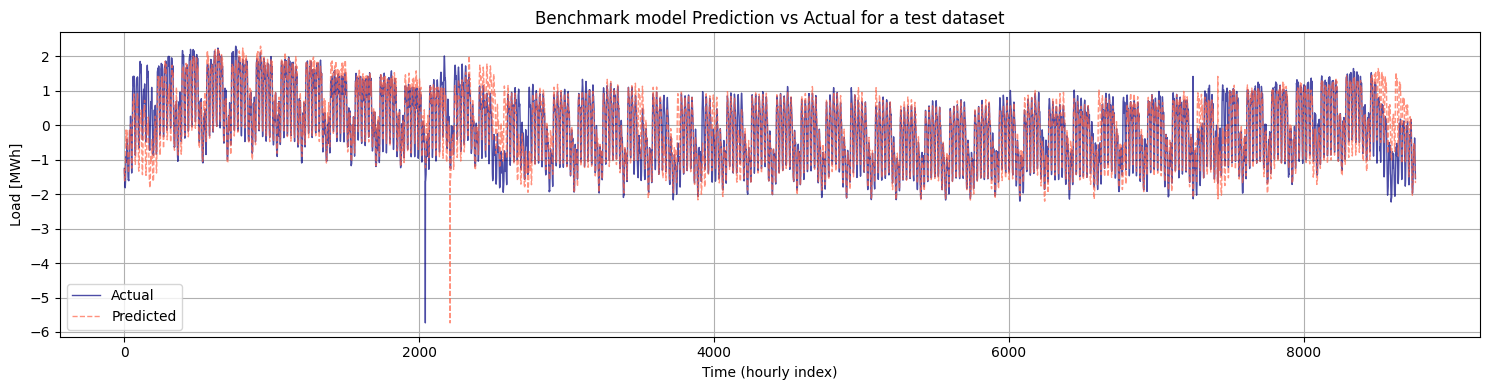

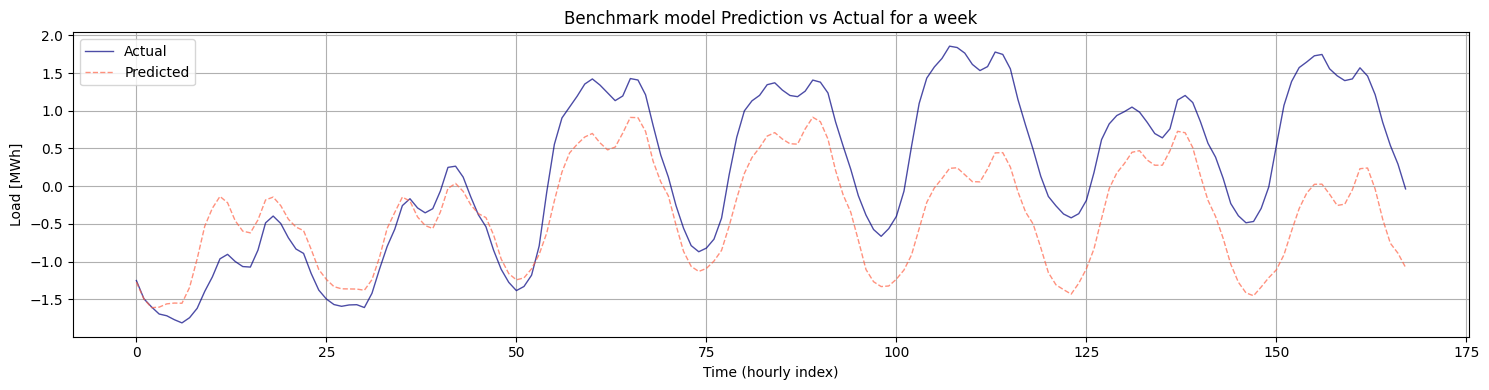

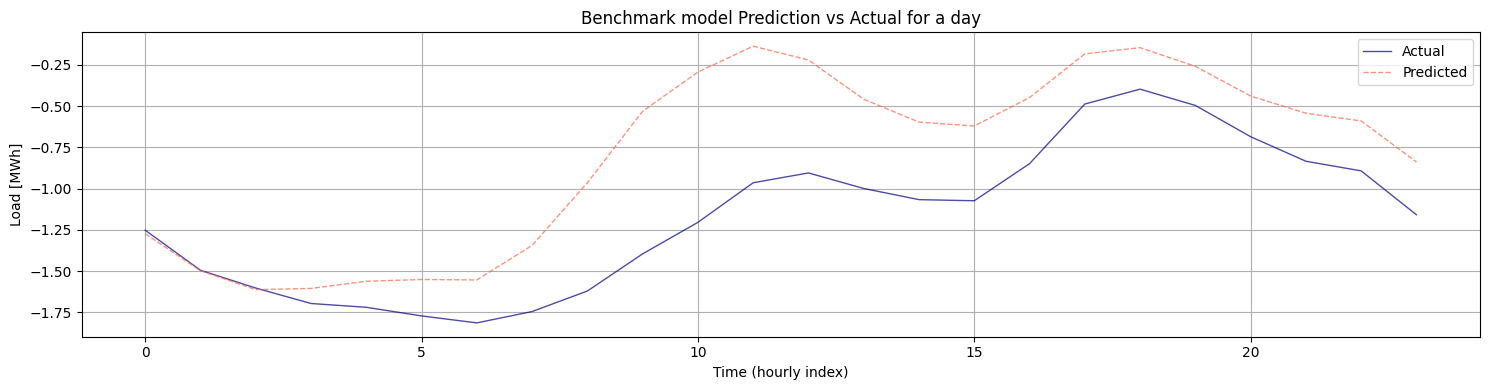

In [48]:
start=0
plot_predictions(
    y_true=y_true_test,
    y_pred=y_pred_test,
    title="Benchmark model Prediction vs Actual for a test dataset",
    start=0,
    end=-1 # 원하는 인덱스 범위
)
plot_predictions(
    y_true=y_true_test,
    y_pred=y_pred_test,
    title="Benchmark model Prediction vs Actual for a week",
    start=start,
    end=start+24*7 # 원하는 인덱스 범위
)
plot_predictions(
    y_true=y_true_test,
    y_pred=y_pred_test,
    title="Benchmark model Prediction vs Actual for a day",
    start=start+0,
    end=start+24 # 원하는 인덱스 범위
)

# LSTM MODEL

In [60]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_col, window_size):
        self.X = []
        self.y = []
        self.indices = data.index
        for i in range(len(data) - window_size):
            x_seq = data.iloc[i:i+window_size].drop(target_col, axis=1).values
            y_val = data.iloc[i+window_size][target_col]
            self.X.append(x_seq)
            self.y.append(y_val)

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [61]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]
        output = self.fc(last_hidden)
        return output.squeeze()


In [62]:
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Train Loss = {total_loss / len(train_loader):.4f}")

    return model


In [112]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# # --- 설정 --- #
# target_col = 'Load [MWh]'
# window_size = 24
# batch_size = 64
# train_size = 105216 

# # --- Train/Test Split --- #
# train_data = final_data.iloc[:train_size]
# test_data = final_data.iloc[train_size:]

# # --- Dataset & DataLoader --- #
# train_dataset = TimeSeriesDataset(train_data, target_col, window_size)
# test_dataset = TimeSeriesDataset(test_data, target_col, window_size)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # --- Model --- #
# input_size = final_data.shape[1] - 1  # exclude target column
# model = LSTMRegressor(input_size=input_size)

# # --- Train --- #
# model = train_model(model, train_loader, val_loader=None, epochs=30, lr=1e-3)

# # --- Prediction Function --- #
# def predict(model, data_loader):
#     model.eval()
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     y_preds, y_trues = [], []
#     with torch.no_grad():
#         for X_batch, y_batch in data_loader:
#             X_batch = X_batch.to(device)
#             y_pred = model(X_batch)
#             y_preds.append(y_pred.cpu().numpy())
#             y_trues.append(y_batch.numpy())
#     return np.concatenate(y_trues), np.concatenate(y_preds)

# # --- Predict Train/Test --- #
# y_true_train, y_pred_train = predict(model, train_loader)
# y_true_test, y_pred_test = predict(model, test_loader)



# DAY AHEAD LSTM MODEL

In [113]:
class DayAheadDataset(Dataset):
    def __init__(self, data, target_col, input_window=24, output_horizon=24):
        self.X = []
        self.y = []
        self.indices = []

        for i in range(len(data) - input_window - output_horizon):
            current_time = data.index[i + input_window]
            if current_time.hour != 0:
                continue  # only use samples where prediction starts at midnight

            x_seq = data.iloc[i:i + input_window].drop(target_col, axis=1).values
            y_seq = data.iloc[i + input_window:i + input_window + output_horizon][target_col].values

            self.X.append(x_seq)
            self.y.append(y_seq)
            self.indices.append(current_time)

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [114]:
class LSTMRegressorMulti(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_horizon=24):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_horizon)

    def forward(self, x):
        out, _ = self.lstm(x)  # out: [B, T, H]
        last_hidden = out[:, -1, :] 
        output = self.fc(last_hidden)  #  [B, 24]
        return output


In [134]:
24*365*3-24*6

26136

In [141]:
# Split
train_size = 26136
train_data = final_data.iloc[:train_size]
test_data = final_data.iloc[train_size:]

# Dataset & DataLoader
train_dataset = DayAheadDataset(train_data, target_col, input_window=24, output_horizon=24)
test_dataset = DayAheadDataset(test_data, target_col, input_window=24, output_horizon=24)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model
input_size = final_data.shape[1] - 1
model = LSTMRegressorMulti(input_size=input_size, output_horizon=24)
model = train_model(model, train_loader, test_loader, epochs=20)


Epoch 1: Train Loss = 0.8658
Epoch 2: Train Loss = 0.4445
Epoch 3: Train Loss = 0.2868
Epoch 4: Train Loss = 0.2293
Epoch 5: Train Loss = 0.1556
Epoch 6: Train Loss = 0.1048
Epoch 7: Train Loss = 0.0852
Epoch 8: Train Loss = 0.0707
Epoch 9: Train Loss = 0.0613
Epoch 10: Train Loss = 0.0578
Epoch 11: Train Loss = 0.0593
Epoch 12: Train Loss = 0.0528
Epoch 13: Train Loss = 0.0502
Epoch 14: Train Loss = 0.0478
Epoch 15: Train Loss = 0.0465
Epoch 16: Train Loss = 0.0447
Epoch 17: Train Loss = 0.0426
Epoch 18: Train Loss = 0.0413
Epoch 19: Train Loss = 0.0418
Epoch 20: Train Loss = 0.0381


In [142]:

# --- Prediction Function --- #
def predict(model, data_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    y_preds, y_trues = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            y_preds.append(y_pred.cpu().numpy())
            y_trues.append(y_batch.numpy())
    return np.concatenate(y_trues), np.concatenate(y_preds)

# --- Predict Train/Test --- #
y_true_train, y_pred_train = predict(model, train_loader)
y_true_test, y_pred_test = predict(model, test_loader)


In [143]:

metrics_train = compute_metrics(y_true_train, y_pred_train)
metrics_test = compute_metrics(y_true_test, y_pred_test)

print("LSTM")
print("Train:")
for k, v in metrics_train.items():
    print(f"  {k}: {v:.4f}")
print("Test:")
for k, v in metrics_test.items():
    print(f"  {k}: {v:.4f}")


LSTM
Train:
  MAE: 0.1254
  MSE: 0.0357
  RMSE: 0.1889
  MAPE (%): 100.8217
Test:
  MAE: 0.2597
  MSE: 0.1348
  RMSE: 0.3672
  MAPE (%): 154.0278


Overall, LSTM model performs better than benchmark model

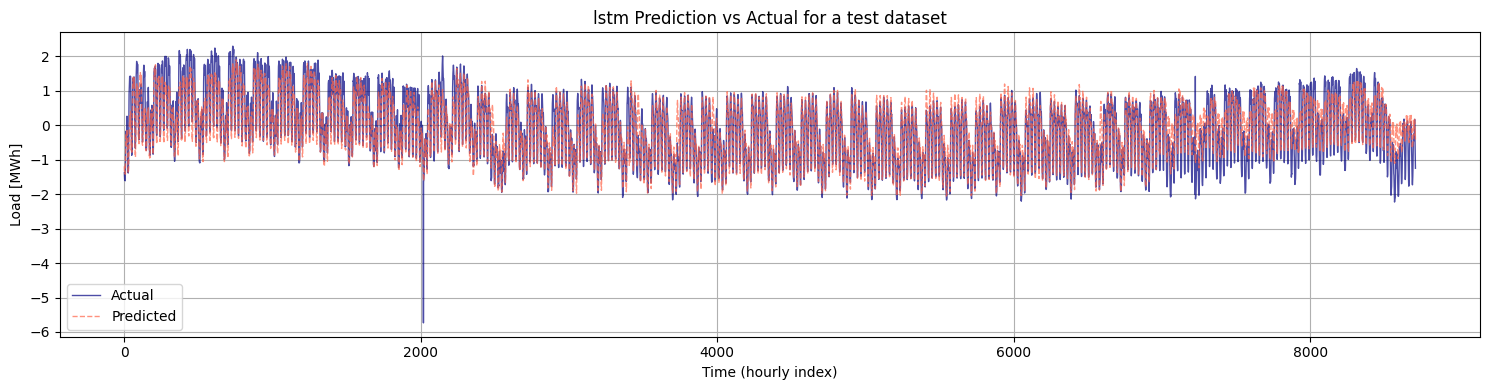

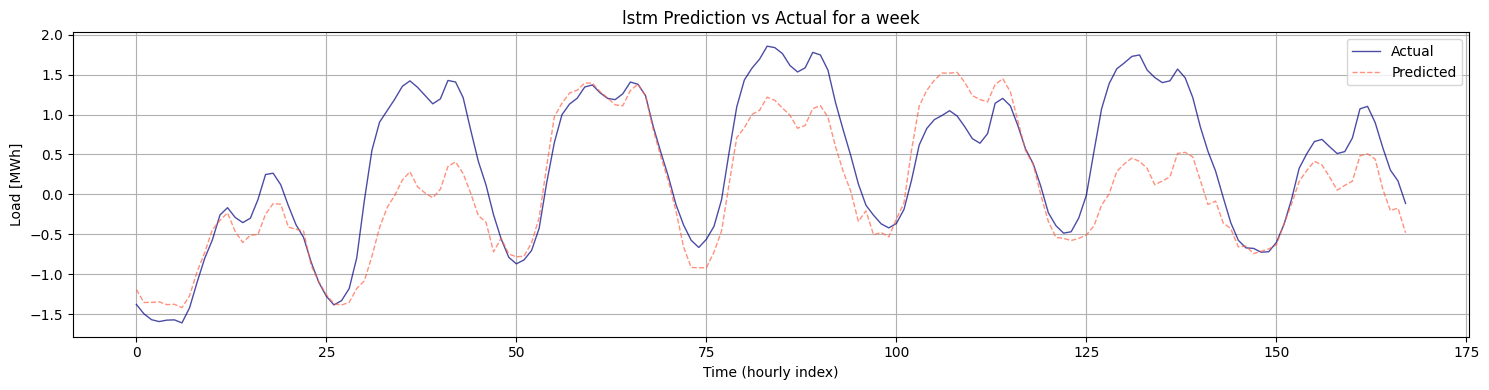

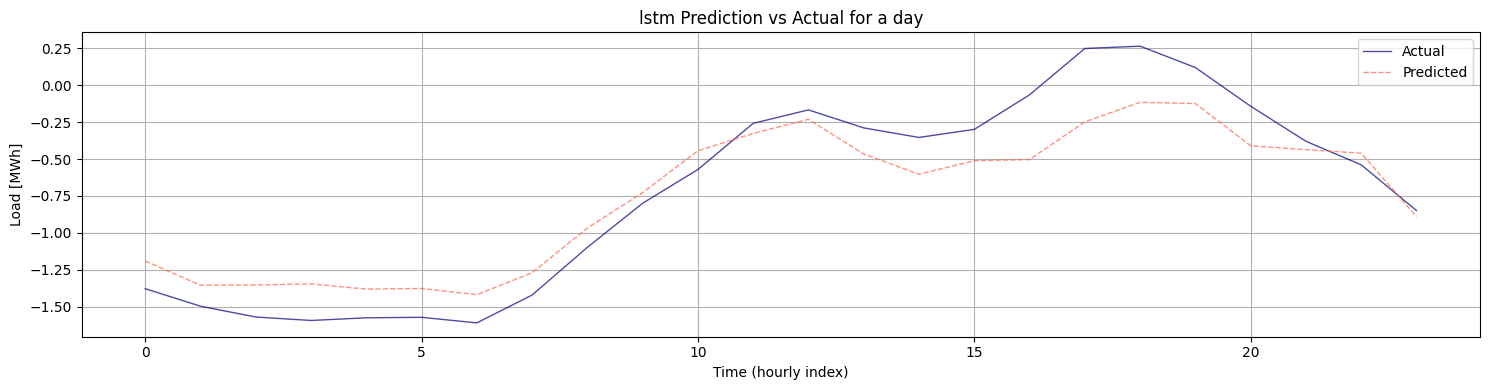

In [144]:
start=0
plot_predictions(
    y_true=y_true_test.flatten(),
    y_pred=y_pred_test.flatten(),
    title="lstm Prediction vs Actual for a test dataset",
    start=0,
    end=-1
)
plot_predictions(
    y_true=y_true_test.flatten(),
    y_pred=y_pred_test.flatten(),
    title="lstm Prediction vs Actual for a week",
    start=start,
    end=start+24*7 
)
plot_predictions(
    y_true=y_true_test.flatten(),
    y_pred=y_pred_test.flatten(),
    title="lstm Prediction vs Actual for a day",
    start=start+0,
    end=start+24 
)